# Super Mario Bros RL Notebook
## Rohan H, Talaal S, Thang N, Yuet W
### University of Bath

![SegmentLocal](mario!.gif "segment")
(we are going to have to delete him sadly...)


### How to run:
The official website for the game environment can be found here: https://pypi.org/project/gym-super-mario-bros/

In a nutshell, you will need:
- Python 3.5/3.6/3.7/3.8 (I have tested on 3.7)
- gymnasium (gym is deprecated)
- ipykernel for running the notebook
- gym-super-mario-bros 
- other essential packages/libraries like NumPy
- an average computer

### Check if the environment works

In [42]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env_example = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='human')
env_example = JoypadSpace(env_example, SIMPLE_MOVEMENT)

test = False
done = True
if test:
    for step in range(1000):
        if done:
            obs, info = env_example.reset()
        obs, reward, terminated, truncated, info = env_example.step(env_example.action_space.sample())
        done = not terminated or truncated

    env_example.close()

c:\Users\robot\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\envs\registration.py:556: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
c:\Users\robot\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\envs\registration.py:628: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  f"The environment creator metadata doesn't include `render_modes`, contains: {list(env_creator.metadata.keys())}"


## Importing Libraries, Defining Functions and Classes

In [43]:
# Rohan's Cell

# YOUR CODE HERE
# example here: https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym.spaces import Box
from gym.wrappers.frame_stack import FrameStack
from gym.core import ObservationWrapper

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as func
from torchvision import transforms as T

from collections import namedtuple, deque
from itertools import count
import itertools

def device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

system = device()

Transition = namedtuple('Transition',
    ['state', 'action', 'next_state', 'reward'])


class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


class DQN_full(nn.Module):

    def __init__(self, shape, actions_n):
        super(DQN_full, self).__init__()
        self.convolution = nn.Sequential(
        nn.Conv2d(shape[0], 32, kernel_size=5, stride=4, padding=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(64, actions_n, kernel_size=3, stride=1, padding=1)
        )

        output_size = self._get_conv_out(shape)
        self.fully_connected = nn.Sequential(
            nn.Linear(output_size, 512),
            nn.Linear(512, actions_n)
        )
    def _get_conv_out(self, shape):
        with torch.no_grad():
            blank = torch.zeros(1, *shape)
            out = self.convolution(blank)
            return int(np.prod(out.size())) 

    def forward(self, x):
        out = self.convolution(x).view(x.size(0), -1)
        return self.fully_connected(out)
    
class DQN_stacked(nn.Module):

    def __init__(self, shape, actions_n):
        super(DQN_stacked, self).__init__()
        self.convolution = nn.Sequential(
        nn.Conv2d(shape[0], 32, kernel_size=5, stride=4, padding=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(64, actions_n, kernel_size=3, stride=1, padding=1)
        )

        output_size = self._get_conv_out(shape)
        self.fully_connected = nn.Sequential(
            nn.Linear(output_size, 512),
            nn.Linear(512, actions_n)
        )
    def _get_conv_out(self, shape):
        with torch.no_grad():
            blank = torch.zeros(1, *shape)
            out = self.convolution(blank)
            return int(np.prod(out.size())) 

    def forward(self, x):
        out = self.convolution(x).view(x.size(0), -1)
        return self.fully_connected(out)

class ReShape(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = env.observation_space.shape
        self.observation_space = Box(
            low=self.observation_space.low.min(),
            high=self.observation_space.high.max(),
            shape=(obs_shape[2], obs_shape[0], obs_shape[1]),
            dtype=env.observation_space.dtype,
        )

    def observation(self, observation):
        return np.transpose(observation, (2, 0, 1))


class GreyScale(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(
            low=0,
            high=1.0,
            shape=(1, env.observation_space.shape[1], env.observation_space.shape[2]),
            dtype=np.uint8,
        )
    def transform(self, observation):
        return np.dot(observation[..., :3], [0.299, 0.587, 0.114]).reshape(1, observation.shape[0], observation.shape[1])

    def observation(self, observation):
        observation = self.transform(observation)
        return observation.astype(np.float32) / 255.0



env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='robot')
env = JoypadSpace(env, [["right"], ["right", "A"]])
env = ReShape(env)
env = GreyScale(env)
print(env.observation_space)

Box(0, 1, (1, 240, 256), uint8)


In [44]:
batch_size = 32
gamma = 0.9 # discount reward
update = 0.05
epsilon_start = 0.9 # exploration
epsilon_end = 0.01
e_decay = 2000

action_n = env.action_space.n
obs, info = env.reset()

network = DQN_full(obs.shape, action_n).to(system)

optimiser = opt.AdamW(network.parameters(), lr=update)
memory = ReplayMemory(1000) #increase to 10000 when training

steps_passed = 0

def select_action(state):
    global steps_passed
    sample = random.random()
    steps_passed += 1
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_passed / e_decay)
    if sample > epsilon:
        with torch.no_grad():
            return network(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=system, dtype=torch.long)


## Model Optimiser

In [45]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=system, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = network(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=system)
    with torch.no_grad():
        next_state_values[non_final_mask] = network(non_final_next_states).max(1).values
    
    # Compute expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimiser.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(network.parameters(), 15)
    optimiser.step()


## Training Loop

Starting Episode  0
tensor([743.])
Starting Episode  1
tensor([632.])
Starting Episode  2
tensor([632.])
Starting Episode  3
tensor([680.])
tensor([680.])
Starting Episode  4
tensor([843.])
Starting Episode  5
tensor([504.])
Starting Episode  6
tensor([743.])
Starting Episode  7
tensor([632.])
Starting Episode  8
tensor([1067.])
tensor([1067.])
Starting Episode  9
tensor([632.])
Starting Episode  10
tensor([1386.])
Starting Episode  11
tensor([1029.])
Starting Episode  12
tensor([680.])
tensor([680.])
Starting Episode  13
tensor([1036.])
tensor([1036.])
Starting Episode  14
tensor([1073.])
Starting Episode  15
tensor([1159.])
Starting Episode  16
tensor([983.])
Starting Episode  17
tensor([871.])
Starting Episode  18
tensor([504.])
Starting Episode  19
tensor([504.])
Starting Episode  20
tensor([504.])
Starting Episode  21
tensor([632.])
Starting Episode  22
tensor([765.])
Starting Episode  23
tensor([808.])
Starting Episode  24
tensor([871.])
Done Training


RuntimeError: matplotlib does not support generators as input

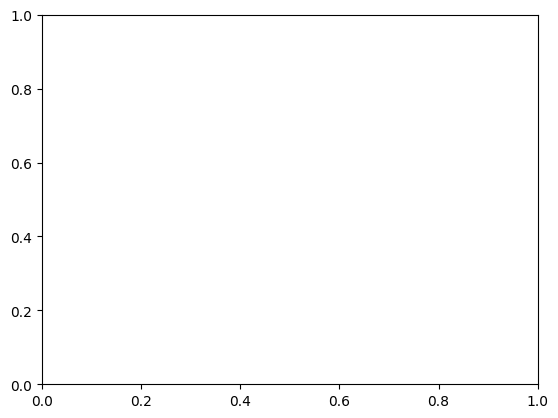

In [ ]:
if system == torch.device("cuda"):
    episodes = 600
else:
    episodes = 25

episode_rewards = []
episode_steps = []

for episode_n in range(episodes):
    print("Starting Episode ", episode_n)
    state, info = env.reset()
    state = torch.tensor(state.copy(), dtype=torch.float32, device=system).unsqueeze(0)
    total_reward = 0
    for i in range(1000):  # count():
        action = select_action(state)
        obs, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=system)
        done = terminated or truncated
        total_reward += reward
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obs, dtype=torch.float32, device=system).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()

        if done:
            episode_steps.append(i+1)
            episode_rewards.append(total_reward)
            print(total_reward)
            break
    
    episode_steps.append(i+1)
    episode_rewards.append(total_reward)
    print(total_reward)

print('Done Training')
